In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier
import json

In [4]:
# Cargar los datos
df = pd.read_csv('../data/stroke_dataset.csv')
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [3]:
# Definir características
numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])


In [4]:
# Definir escenarios y modelos
scenarios = [
    (" *** Dataset Original *** ", df),
    (" *** Sin menores de 14 años ***", df[df['age'] >= 14]),
    (" *** Sin valores desconocidos en Smoking Status", df[df['smoking_status'] != 'Unknown']),
    (" *** Nueva categoría par desconocidos en Smoking Status", df.replace({'smoking_status': {'Unknown': 'No Information'}}))
]

In [5]:
models = [
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("XGBoost", XGBClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(random_state=42, verbose=False))
]

In [6]:
# Iterar sobre escenarios
for scenario_name, scenario_df in scenarios:
    print(f"\n*** ESCENARIO: {scenario_name} *** ")
    
    # Dividir características y objetivo
    X = scenario_df.drop('stroke', axis=1)
    y = scenario_df['stroke']
    
    # Dividir en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Iterar sobre modelos
    for model_name, model in models:
        print(f"\n{model_name} SIN técnicas de balanceo SMOTE:")
        
        # Crear y entrenar pipeline sin SMOTE
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
        
        # Predecir y evaluar
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        print(f"\n{model_name} CON técnicas de balanceo SMOTE:")
        
        # Crear y entrenar pipeline con SMOTE
        pipeline_smote = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
        pipeline_smote.fit(X_train, y_train)
        
        # Predecir y evaluar
        y_pred_smote = pipeline_smote.predict(X_test)
        y_pred_proba_smote = pipeline_smote.predict_proba(X_test)[:, 1]
        
        print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_smote):.4f}")
        print(f"F1-Score: {f1_score(y_test, y_pred_smote):.4f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred_smote))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_smote))


*** ESCENARIO:  *** Dataset Original ***  *** 

Logistic Regression SIN técnicas de balanceo SMOTE:
AUC-ROC: 0.8463
F1-Score: 0.0000

Confusion Matrix:
[[947   0]
 [ 50   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       947
           1       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.93       997


Logistic Regression CON técnicas de balanceo SMOTE:
AUC-ROC: 0.8381
F1-Score: 0.2448

Confusion Matrix:
[[703 244]
 [  9  41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       947
           1       0.14      0.82      0.24        50

    accuracy                           0.75       997
   macro avg       0.57      0.78      0.55       997
weighted avg       0.95      0.75      0.82      

c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.8217
F1-Score: 0.0000

Confusion Matrix:
[[945   2]
 [ 50   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       947
           1       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.92       997


Random Forest CON técnicas de balanceo SMOTE:
AUC-ROC: 0.8247
F1-Score: 0.1053

Confusion Matrix:
[[907  40]
 [ 45   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       947
           1       0.11      0.10      0.11        50

    accuracy                           0.91       997
   macro avg       0.53      0.53      0.53       997
weighted avg       0.91      0.91      0.91       997


XGBoost SIN técnicas de balanceo SMOTE:
AUC-ROC: 0.8012
F1-Score: 0.0351

Confusion Matrix:
[[941   

c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.7404
F1-Score: 0.0000

Confusion Matrix:
[[656   1]
 [ 40   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       657
           1       0.00      0.00      0.00        40

    accuracy                           0.94       697
   macro avg       0.47      0.50      0.48       697
weighted avg       0.89      0.94      0.91       697


Random Forest CON técnicas de balanceo SMOTE:
AUC-ROC: 0.7466
F1-Score: 0.1143

Confusion Matrix:
[[631  26]
 [ 36   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       657
           1       0.13      0.10      0.11        40

    accuracy                           0.91       697
   macro avg       0.54      0.53      0.53       697
weighted avg       0.90      0.91      0.91       697


XGBoost SIN técnicas de balanceo SMOTE:
AUC-ROC: 0.7732
F1-Score: 0.1034

Confusion Matrix:
[[642  1

c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.8217
F1-Score: 0.0000

Confusion Matrix:
[[945   2]
 [ 50   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       947
           1       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.92       997


Random Forest CON técnicas de balanceo SMOTE:
AUC-ROC: 0.8247
F1-Score: 0.1053

Confusion Matrix:
[[907  40]
 [ 45   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       947
           1       0.11      0.10      0.11        50

    accuracy                           0.91       997
   macro avg       0.53      0.53      0.53       997
weighted avg       0.91      0.91      0.91       997


XGBoost SIN técnicas de balanceo SMOTE:
AUC-ROC: 0.8012
F1-Score: 0.0351

Confusion Matrix:
[[941   

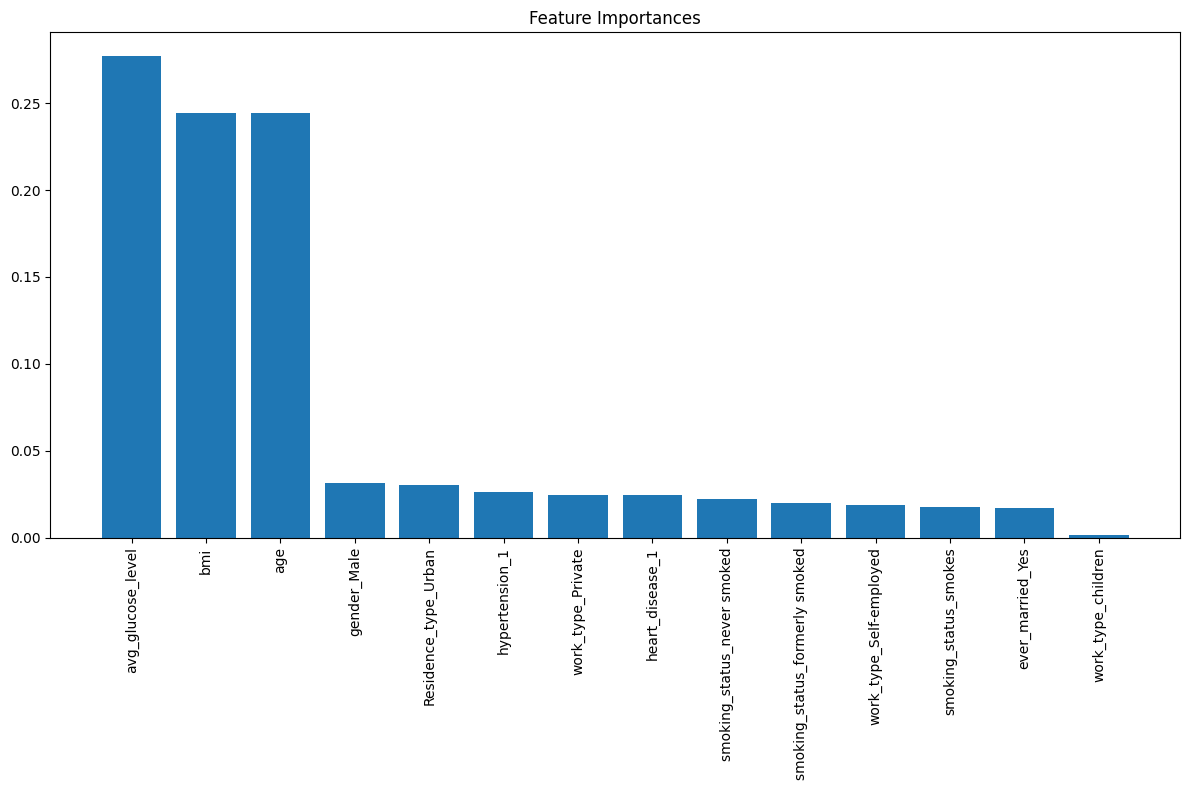

In [7]:
# Visualización de importancia de características (para Random Forest)
X = df.drop('stroke', axis=1)
y = df['stroke']

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipeline_rf.fit(X, y)

feature_names = (numeric_features + 
                pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features).tolist())

importances = pipeline_rf.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## **Logistic Regression**

* Sin SMOTE: F1-Score para la clase 1 es 0, lo que indica que no se predicen casos de la clase minoritaria.
* Con SMOTE: Mejora notable en la clase 1 (F1-Score = 0.24), pero a costa de sacrificar algo de precisión en la clase 0.
## **Random Forest**

* Sin SMOTE: Igual que en la regresión logística, el modelo ignora la clase minoritaria (F1-Score de 0).
* Con SMOTE: Aunque mejora la predicción de la clase 1 (F1-Score de 0.10), sigue siendo relativamente baja, lo que indica que este algoritmo tiene dificultades con el desbalance incluso con SMOTE.
## **XGBoost**

* Sin SMOTE: Ligeramente mejor que Random Forest en cuanto a la predicción de la clase 1, pero el rendimiento sigue siendo muy bajo.
* Con SMOTE: Aumento moderado en el F1-Score para la clase 1, pero sigue estando por debajo de Logistic Regression con SMOTE.
## **CatBoost**

* Sin SMOTE: Presenta un comportamiento similar a XGBoost, ignorando en gran parte la clase minoritaria.
* Con SMOTE: Mejora la predicción de la clase 1, pero el F1-Score sigue siendo bajo, aunque ligeramente superior a Random Forest.

* Logistic Regression con SMOTE parece ser el enfoque que mejor equilibra el rendimiento entre ambas clases, logrando el mejor F1-Score para la clase minoritaria.
* Modelos como Random Forest y CatBoost, incluso con SMOTE, no logran predecir bien la clase minoritaria, lo que sugiere que estos modelos podrían no ser los más adecuados para este problema en particular.
* Compromiso entre clases: La mejora en la predicción de la clase minoritaria viene con una reducción en el rendimiento para la clase mayoritaria. Este compromiso es inevitable en problemas de clasificación desbalanceada.

# **Análisis de cada escenario**
1. ***Dataset Original***
* Ventajas:
Utilizas toda la información disponible en el conjunto de datos.
No se pierden registros por filtrado o eliminación.
* Desventajas:
Los valores desconocidos en variables como Smoking Status pueden introducir ruido o sesgo en el modelo.
Resultados:
- Sin SMOTE: Los modelos tienden a ignorar la clase minoritaria (F1-Score muy bajo o cero).
- Con SMOTE: Mejora significativa en la predicción de la clase minoritaria, especialmente con Regresión Logística (F1-Score de 0.2448).
2. ***Sin menores de 14 año***
* Ventajas:
Eliminar a los menores de 14 años puede reducir la variabilidad si este grupo no es relevante para el problema (por ejemplo, si el evento de interés es raro en este grupo de edad).
* Desventajas:
Reduces el tamaño del conjunto de datos, lo que puede afectar la capacidad del modelo para generalizar.
Posible pérdida de información valiosa si los menores de 14 años son relevantes.
Resultados:
- Sin SMOTE: Los modelos siguen sin predecir adecuadamente la clase minoritaria.
- Con SMOTE: Mejora en la predicción de la clase minoritaria, pero el F1-Score sigue siendo relativamente bajo comparado con el Dataset Original.
3. ***Sin valores desconocidos en Smoking Status***
* Ventajas:
Trabajas con datos más limpios al eliminar los valores desconocidos.
* Desventajas:
Pierdes una cantidad significativa de registros (de 997 a 697), lo que puede afectar el rendimiento del modelo.
Posible introducción de sesgo si los valores desconocidos no están distribuidos aleatoriamente.
Resultados:
- Sin SMOTE: Los modelos no logran predecir la clase minoritaria (F1-Score de 0).
- Con SMOTE: Ligera mejora, pero el F1-Score para la clase minoritaria sigue siendo bajo (máximo de 0.2239 con Regresión Logística).
4. ***Nueva categoría para desconocidos en Smoking Status***
* Ventajas:
Conservas todos los registros, incluyendo aquellos con valores desconocidos en Smoking Status.
Permites que el modelo aprenda patrones asociados a los casos con estado de tabaquismo desconocido.
* Desventajas:
Si los valores desconocidos son aleatorios, la nueva categoría puede introducir ruido.
Resultados:
- Sin SMOTE: Los modelos aún tienen dificultades para predecir la clase minoritaria.
- Con SMOTE: Regresión Logística nuevamente muestra el mejor desempeño (F1-Score de 0.2448), similar al Dataset Original.
***Comparación y recomendación**
Comparando los escenarios, observamos que:

* Eliminación de registros (Escenarios 2 y 3) reduce el tamaño del conjunto de datos, lo que puede afectar negativamente al modelo debido a menos información disponible para el entrenamiento.
* Mantener todos los datos (Escenarios 1 y 4) permite al modelo aprender de toda la información disponible, incluyendo posibles patrones en los valores desconocidos.
* El Escenario 4 es especialmente interesante porque:

Maneja los valores desconocidos de manera explícita, permitiendo al modelo considerar la ausencia de información como una categoría en sí misma.
Evita la pérdida de datos que ocurre al eliminar registros con valores desconocidos.
Resultados similares o ligeramente mejores en comparación con el Dataset Original, especialmente al usar Regresión Logística con SMOTE.
Recomendación:

El **Escenario 4 (Nueva categoría para desconocidos en Smoking Status)** parece ser el más adecuado por las siguientes razones:

* Conservación de datos: No se pierden registros por eliminación, manteniendo el tamaño del conjunto de datos y la diversidad de la información.

* Manejo efectivo de valores faltantes: Al tratar los valores desconocidos como una categoría aparte, permites que el modelo identifique patrones específicos asociados a esta nueva categoría.

* Mejores resultados en la predicción de la clase minoritaria: Aunque los resultados son similares al Dataset Original, el manejo explícito de los valores desconocidos puede ofrecer una ligera ventaja.

* Balance entre precisión y recall: La **Regresión Logística con SMOTE** en este escenario ofrece un mejor equilibrio, con un **F1-Score de 0.2448** para la clase minoritaria, lo que indica una mejora en la predicción de casos positivos.

* Conclusión:
Escenario más adecuado: Escenario 4 (Nueva categoría para desconocidos en Smoking Status).
Modelo recomendado: Regresión Logística con SMOTE.
Justificación:
Conserva toda la información disponible sin eliminar registros.
Maneja adecuadamente los valores desconocidos, permitiendo que el modelo aprenda de ellos.
Mejora significativa en la predicción de la clase minoritaria sin sacrificar demasiado el rendimiento en la clase mayoritaria.
Facilita un mejor equilibrio entre precisión y recall para ambas clases.


In [13]:
import optuna
from sklearn.model_selection import cross_val_score

# Función objetivo para Optuna
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 1e-5, 100)
    penalty = trial.suggest_categorical('penalty', ['l2', None])
    
    # Modelo con hiperparámetros
    model = LogisticRegression(C=C, penalty=penalty, random_state=42)
    
    # Pipeline con preprocesador
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Realizamos validación cruzada
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1').mean()
    
    return score

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mejor resultado
print(f"Mejor resultado: {study.best_trial.value}")
print(f"Mejores hiperparámetros: {study.best_trial.params}")


[I 2024-10-13 20:50:31,163] A new study created in memory with name: no-name-6fe0bcae-c533-4467-b1c7-78e1ffa17cae
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11780\4022636100.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 100)
[I 2024-10-13 20:50:31,332] Trial 0 finished with value: 0.0 and parameters: {'C': 0.0006273929187912594, 'penalty': 'l2'}. Best is trial 0 with value: 0.0.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11780\4022636100.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 100)
[I 2024-10-13 20:50:31,537] Trial 1 finished with value: 0.0097560975609756

Mejor resultado: 0.00975609756097561
Mejores hiperparámetros: {'C': 1.4336969210235382, 'penalty': 'l2'}


In [14]:
# Entrenar el modelo con los mejores parámetros encontrados
best_model = LogisticRegression(C=1.4337, penalty='l2', random_state=42, solver='saga')

# Crear pipeline con preprocesamiento
pipeline_best = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Entrenar el modelo
pipeline_best.fit(X_train, y_train)

# Evaluar el modelo
y_pred_best = pipeline_best.predict(X_test)
y_pred_proba_best = pipeline_best.predict_proba(X_test)[:, 1]

# Métricas de evaluación
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


AUC-ROC: 0.8464
F1-Score: 0.0000

Confusion Matrix:
[[947   0]
 [ 50   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       947
           1       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.93       997



c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\G5-DScience\G5_D.Scientist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Crear el modelo con los mejores parámetros encontrados
best_model = LogisticRegression(C=1.4337, penalty='l2', random_state=42, solver='saga')

# Crear pipeline con preprocesamiento y SMOTE
pipeline_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Aplicar SMOTE
    ('classifier', best_model)
])

# Entrenar el modelo
pipeline_smote.fit(X_train, y_train)

# Evaluar el modelo
y_pred_smote = pipeline_smote.predict(X_test)
y_pred_proba_smote = pipeline_smote.predict_proba(X_test)[:, 1]

# Métricas de evaluación
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_smote):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_smote):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))


AUC-ROC: 0.8380
F1-Score: 0.2455

Confusion Matrix:
[[704 243]
 [  9  41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       947
           1       0.14      0.82      0.25        50

    accuracy                           0.75       997
   macro avg       0.57      0.78      0.55       997
weighted avg       0.95      0.75      0.82       997



In [16]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
cv_scores = cross_val_score(pipeline_best, X_train, y_train, cv=5, scoring='f1')
print(f"F1-Score promedio en validación cruzada: {cv_scores.mean():.4f}")


F1-Score promedio en validación cruzada: 0.0098


In [11]:
from sklearn.model_selection import cross_val_score

# Ejemplo de validación cruzada para Logistic Regression
model = LogisticRegression(random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Realizamos validación cruzada
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"F1-Score promedio en validación cruzada: {scores.mean():.4f}")


F1-Score promedio en validación cruzada: 0.0098


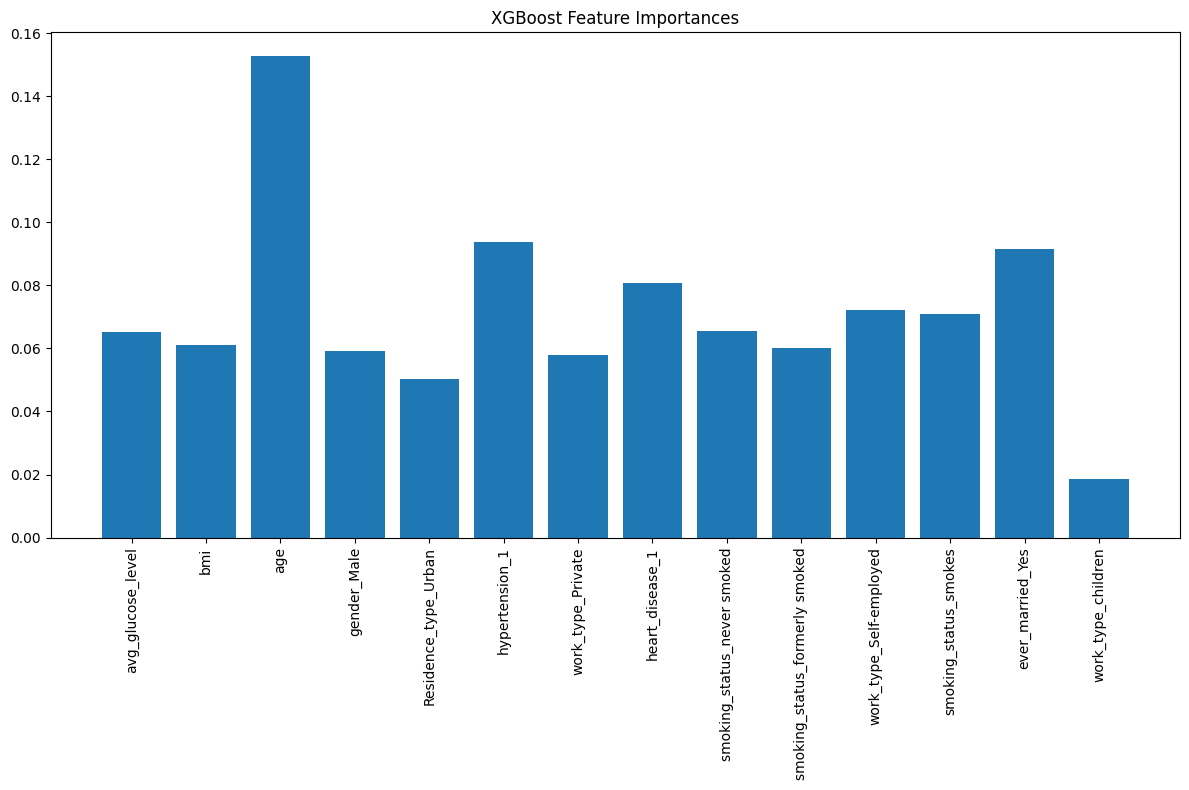

In [12]:
# Importancia de características en XGBoost
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])
pipeline_xgb.fit(X, y)

importances_xgb = pipeline_xgb.named_steps['classifier'].feature_importances_

plt.figure(figsize=(12, 8))
plt.title("XGBoost Feature Importances")
plt.bar(range(len(importances_xgb)), importances_xgb[indices])
plt.xticks(range(len(importances_xgb)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()
